In [1]:
import os
import cv2
import numpy as np
import glob
import math
import scipy
from scipy.spatial import distance
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from tqdm import tqdm_notebook as tqdm
from IrisLocalization import IrisLocalization
from IrisNormalization import IrisNormalization
from ImageEnhancement import ImageEnhancement
from FeatureExtraction import FeatureExtraction
from IrisMatching import IrisMatching
from PerformanceEvaluation import PerformanceEvaluation
import warnings
warnings.filterwarnings("ignore")

In [2]:
images_path = [file for file in sorted(glob.glob("../../Datasets/CASIA1/*/*.jpg"))]
images_test_path = [file for file in sorted(glob.glob("../../Datasets/CASIA1/*/*_4.jpg"))]
images_train_path = [file for file in sorted(glob.glob("../../Datasets/CASIA1/*/*.jpg")) if file not in images_test_path]
len(images_path), len(images_train_path), len(images_test_path)

(756, 648, 108)

In [3]:
'''TRAINING'''

#reading the training images from the CASIA dataset
print("Reading Training Images...")
images_train = [cv2.imread(file) for file in images_train_path] #[cv2.imread(path+file) for file in os.listdir(path)]

# running Localization, Normalization,Enhancement and Feature Extraction on all the training images
boundary_train,centers_train=IrisLocalization(images_train)
normalized_train=IrisNormalization(boundary_train,centers_train)
enhanced_train=ImageEnhancement(normalized_train)
feature_vector_train=FeatureExtraction(enhanced_train)
print("Training data processed.")

Reading Training Images...


Localizing Iris...:   0%|          | 0/648 [00:00<?, ?it/s]

Normalizing...:   0%|          | 0/648 [00:00<?, ?it/s]

Extracting Features...:   0%|          | 0/648 [00:00<?, ?it/s]

Training data processed.


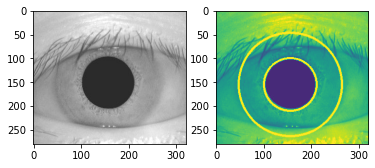

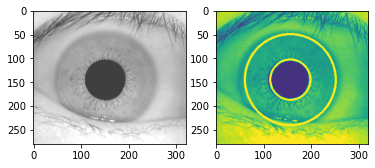

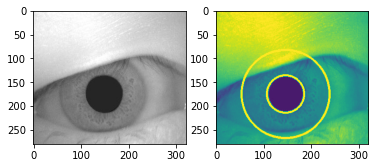

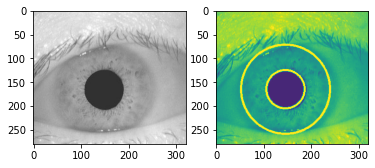

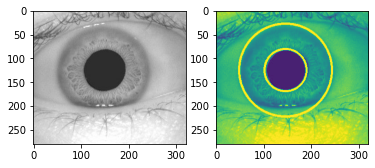

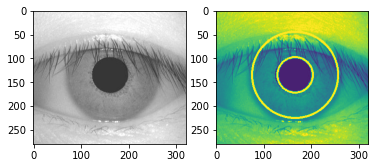

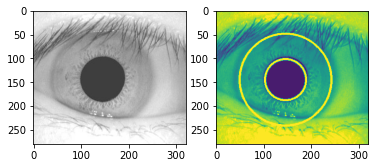

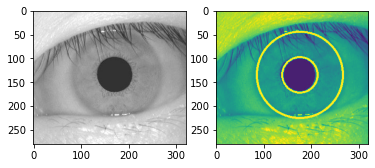

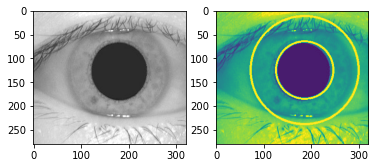

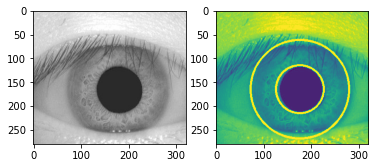

In [4]:
for x in range(10):
    i = np.random.randint(len(images_train_path))
    plt.subplot2grid(shape=(1,2), loc=(0,0))
    plt.imshow(images_train[i])
    plt.subplot2grid(shape=(1,2), loc=(0,1))
    plt.imshow(boundary_train[i])

    plt.show()

In [5]:
len(feature_vector_train[0])

1536

In [6]:
'''TESTING'''

#reading the testing images from the CASIA dataset
print("Reading Testing Images...")
images_test = [cv2.imread(file) for file in images_test_path]

#running Localization, Normalization,Enhancement and Feature Extraction on all the testing images
boundary_test,centers_test=IrisLocalization(images_test)
normalized_test=IrisNormalization(boundary_test,centers_test)
enhanced_test=ImageEnhancement(normalized_test)
feature_vector_test=FeatureExtraction(enhanced_test)
print("Testing data processed.")

Reading Testing Images...


Localizing Iris...:   0%|          | 0/108 [00:00<?, ?it/s]

Normalizing...:   0%|          | 0/108 [00:00<?, ?it/s]

Extracting Features...:   0%|          | 0/108 [00:00<?, ?it/s]

Testing data processed.


In [7]:
crr_L1=[]
crr_L2=[]
crr_cosine=[]
y_test=[]
y_pred=[]
match_cosine=[]
match_cosine_ROC=[]

#Performing Matching and CRR scores for 10,40,60,80,90,107 number of dimensions in the reduced feature vector
components=[10,40,60,80,90,107]

In [8]:
print("Begin Matching test data with the train data")
for comp in tqdm(components):
    
    #Running matching for all the dimensions specified in "components" 
    comp_match_L1,comp_match_L2,comp_match_cosine,comp_match_cosine_ROC=IrisMatching(feature_vector_train,feature_vector_test,comp,1)
    
    #Calculating CRR for all the dimensions specified in "components" 
    comp_crr_L1,comp_crr_L2,comp_crr_cosine=PerformanceEvaluation(comp_match_L1,comp_match_L2,comp_match_cosine)
    
    #combining the results of all the dimensional feature vector into one array
    crr_L1.append(comp_crr_L1)
    crr_L2.append(comp_crr_L2)
    crr_cosine.append(comp_crr_cosine)
    match_cosine.append(comp_match_cosine)
    match_cosine_ROC.append(comp_match_cosine_ROC)

Begin Matching test data with the train data


  0%|          | 0/6 [00:00<?, ?it/s]

Matching...:   0%|          | 0/108 [00:00<?, ?it/s]

Matching...:   0%|          | 0/108 [00:00<?, ?it/s]

Matching...:   0%|          | 0/108 [00:00<?, ?it/s]

Matching...:   0%|          | 0/108 [00:00<?, ?it/s]

Matching...:   0%|          | 0/108 [00:00<?, ?it/s]

Matching...:   0%|          | 0/108 [00:00<?, ?it/s]

In [9]:
orig_match_L1,orig_match_L2,orig_match_cosine,orig_match_cosine_ROC=IrisMatching(feature_vector_train,feature_vector_test,0,1)
orig_crr_L1,orig_crr_L2,orig_crr_cosine=PerformanceEvaluation(orig_match_L1,orig_match_L2,orig_match_cosine)  
print("Completed Matching")

Matching...:   0%|          | 0/108 [00:00<?, ?it/s]

Completed Matching


In [10]:
#Table for CRR rates for the original and reduced feature set(components=107)
print('\n\n\n')
dict={'Similarity Measure':['L1','L2','Cosine Distance'],'CRR for Original Feature Set':[orig_crr_L1,orig_crr_L2,orig_crr_cosine],'CRR for Reduced Feature Set (107)':[crr_L1[5],crr_L2[5],crr_cosine[5]]}
table=pd.DataFrame(dict)
print("Recognition results using Different Similarity Measures : \n")
print(table.iloc[0],"\n")
print(table.iloc[1],"\n")
print(table.iloc[2])





Recognition results using Different Similarity Measures : 

Similarity Measure                    L1
CRR for Original Feature Set         0.0
CRR for Reduced Feature Set (107)    0.0
Name: 0, dtype: object 

Similarity Measure                    L2
CRR for Original Feature Set         0.0
CRR for Reduced Feature Set (107)    0.0
Name: 1, dtype: object 

Similarity Measure                   Cosine Distance
CRR for Original Feature Set                     0.0
CRR for Reduced Feature Set (107)                0.0
Name: 2, dtype: object


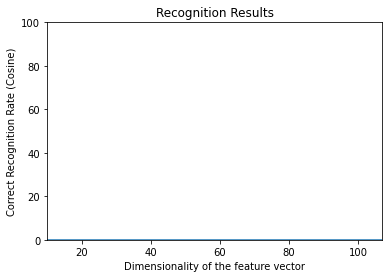

In [11]:
# Plotting the incresing CRR for cosine similarity with the incresing dimensionality
plt.plot(components,crr_cosine)
plt.axis([10,107,0,100])
plt.ylabel('Correct Recognition Rate (Cosine)')
plt.xlabel('Dimensionality of the feature vector')
plt.title('Recognition Results')
plt.show()

In [12]:
#Calculating the false positive and the true positive rates for the data
#We have taken match_cosine[5] because the 5th instance of the array is for the 107 reduced feature dimension
fmr_all=[]
fnmr_all=[]

for q in range(0,3):
    false_accept=0
    false_reject=0
    num_1=len([i for i in match_cosine_ROC[5][q] if i==1])
    num_0=len([i for i in match_cosine_ROC[5][q] if i==0])

    for p in range(0,len(match_cosine[5])):
        if match_cosine[5][p]==0 and match_cosine_ROC[5][q][p]==1:
            false_accept+=1
        if match_cosine[5][p]==1 and match_cosine_ROC[5][q][p]==0:
            false_reject+=1
    fmr=false_accept/num_1
    fnmr=false_reject/num_0
    thresh=[0.4,0.5,0.6]
    fmr_all.append(fmr)
    fnmr_all.append(fnmr)

ZeroDivisionError: division by zero

In [13]:
dict1={'Threshold':thresh,'FMR':fmr_all,'FNMR':fnmr_all}
roc_table=pd.DataFrame(dict1)
print("ROC Measures : \n")
print(roc_table.iloc[0],"\n")
print(roc_table.iloc[1],"\n")
print(roc_table.iloc[2])

NameError: name 'thresh' is not defined

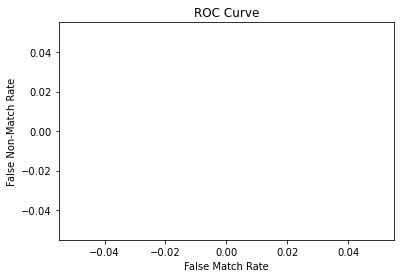

In [14]:
#Plotting the ROC Curve
plt.plot(fnmr_all,fmr_all)
plt.title('ROC Curve')
plt.ylabel('False Non-Match Rate')
plt.xlabel('False Match Rate')
plt.show()
